In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import pickle
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import easydict

In [2]:
sujets = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
times = ['2017-10-23_100057','2017-09-26_095637', '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250', '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313', '2017-11-08_150410','2017-11-17_172706']

In [3]:
def moulti_fit(sujet, trial, nb_fit=50, perturbation=200):
    with open('data/enregistrement_%s_%s.pkl'%(sujets[sujet], times[sujet]), 'rb') as fichier :
        exp = pickle.load(fichier, encoding='latin1')
    datafile = 'data/enregistrement_%s_%s.asc'%(sujets[sujet], times[sujet])

    A = ANEMO(exp) 
    Fit = ANEMO.Fit(exp)
    Plot = ANEMO.Plot(exp)

    #= 1 ===============================================================================================
    data_full = read_edf(datafile, 'TRIALID')

    Plot.plot_fit(data_full, trials=trial, fig_width=30)

    arg = A.arg(data_full[trial], trial=trial, block=0)
    velocity = A.velocity_NAN(**arg)
    old_latency, old_steady_state, old_anti = A.classical_method.Full(velocity, arg.TargetOn-arg.t_0)
    rere = Fit.Fit_trial(velocity, value_latency=old_latency, value_steady_state=old_steady_state, value_anti=old_anti, **arg)
    
    result_full_data = rere.values
    for k in ['latency', 'start_anti'] :
        result_full_data[k] = result_full_data[k] - (arg.TargetOn-arg.t_0)
    #print('result_full_data =', result_full_data)

    #= 2 ===============================================================================================
    color = 'g'
    result_red_data = []
    
    #-------------------------------------------------------------------------------
    max_latency = len(arg.trackertime[:-280])
    
    #-------------------------------------------------------------------------------
    np.random.seed(10)
    if old_latency >= max_latency-50 : old_latency = max_latency-150
    if old_latency > 250 :             old_latency = arg.TargetOn-arg.t_0+100
    if np.isnan(old_latency) :         old_latency = arg.TargetOn-arg.t_0+100
    list_latency = old_latency + perturbation*np.random.rand(nb_fit)*np.random.choice([-1,1], nb_fit)
    print(list_latency)
    
    #-------------------------------------------------------------------------------
    for value_latency in list_latency :

        param_fit=[{'name':'steady_state', 'value':old_steady_state, 'min':5., 'max':40., 'vary':True},
                   {'name':'dir_target',   'value':arg.dir_target,   'min':None, 'max':None, 'vary':False},
                   {'name':'a_anti',       'value':old_anti,         'min':-40., 'max':40., 'vary':True},
                   {'name':'latency',      'value':value_latency,
                      'min':arg.TargetOn-arg.t_0+75, 'max':max_latency, 'vary':True},
                   {'name':'start_anti',   'value':arg.TargetOn-arg.t_0-100,
                      'min':arg.StimulusOf-arg.t_0-200, 'max':arg.TargetOn-arg.t_0+75, 'vary':'vary'},
                   {'name':'tau',  'value':15., 'min':13., 'max':80., 'vary':'vary'}]
        inde_vars={'x':np.arange(len(arg.trackertime[:-280]))}

        #===================================================================
        rere = Fit.Fit_trial(velocity, param_fit=param_fit, inde_vars=inde_vars, time_sup=280)
        result_red = rere.values

        fit = A.Equation.fct_velocity(arg.trackertime[:-280]-arg.t_0, **result_red)
        plt.plot(arg.trackertime[:-280]-arg.TargetOn, fit, c=color)

        for k in ['latency', 'start_anti'] : result_red[k] = result_red[k] - (arg.TargetOn-arg.t_0)
        result_red_data.append(result_red)

    return(result_full_data, result_red_data)

In [4]:
def histoto(result_full_data_, result_red_data_, name, color, bins=50):
    
    
    x_range = {'steady_state': [ 5,  40], 'a_anti':     [ -40, 40],
               'latency':      [75, 500], 'start_anti': [-500, 75],
               'tau':          [13,  80]}
    
    list_, list_var = result_full_data_[0].keys(), []
    for v in list_: 
        if v not in ['dir_target', 'do_whitening'] : list_var.append(v)

    nb_var = len(list_var)
    fig, ax = plt.subplots(nb_var, len(result_full_data_), figsize=(5*len(result_full_data_),5*nb_var/1.681))
    
    for r in range(len(result_full_data_)) :
        
        result_full_data = result_full_data_[r]
        result_red_data = result_red_data_[r]
        
        
        for nb_var, v in enumerate(list_var) :
        
            result_v = []
            for n in range(len(result_red_data)) :
                result_v.append(result_red_data[n][v])

            hi = ax[nb_var][r].hist(result_v, range=x_range[v], color=color[r], alpha=.7, density=True, bins=bins)#, histtype='step', align='mid')
            ax[nb_var][r].bar(result_full_data[v], np.max(hi[0]), width=(x_range[v][0]-x_range[v][1])/(bins*2), color='k')    
            ax[nb_var][r].set_title(v+name[r], fontsize=20)
            
            ax[nb_var][r].text(x_range[v][1]-(x_range[v][1]-x_range[v][0])/50,
                               np.max(hi[0])-np.max(hi[0])/50,
                               'ref: %.1f\nmean: %.1f +/- %.1f'%(result_full_data[v], np.mean(result_v), np.std(result_v)),
                               ha='right', va='top', fontsize=20)
    plt.tight_layout()

# Good

AM
[1069.26412865  910.84961013  788.27035301 1064.76077651  815.29859754
  870.04067089  954.61257295  762.89385756  881.17783269  897.33203717
  777.92803633  724.32133076  914.21034673 1017.43845268 1077.52419233
 1037.50521337  770.64893651  856.62478637  731.4451755  1057.91515668
 1023.5088736   943.43400952  989.66815201  780.17327699 1003.36663488
  828.19720133 1038.55339569 1017.62764851 1045.07943639  794.79220932
  753.95536063 1019.32943048 1096.72977616  978.8472178   896.90813015
  854.85998867  892.20312763  749.26373474  905.62073612 1040.25742966
 1024.51723118 1078.85739913  954.78950794  743.62993951  985.33052789
 1065.92953831  855.80765862  738.21270409  849.89767243  948.00317954]


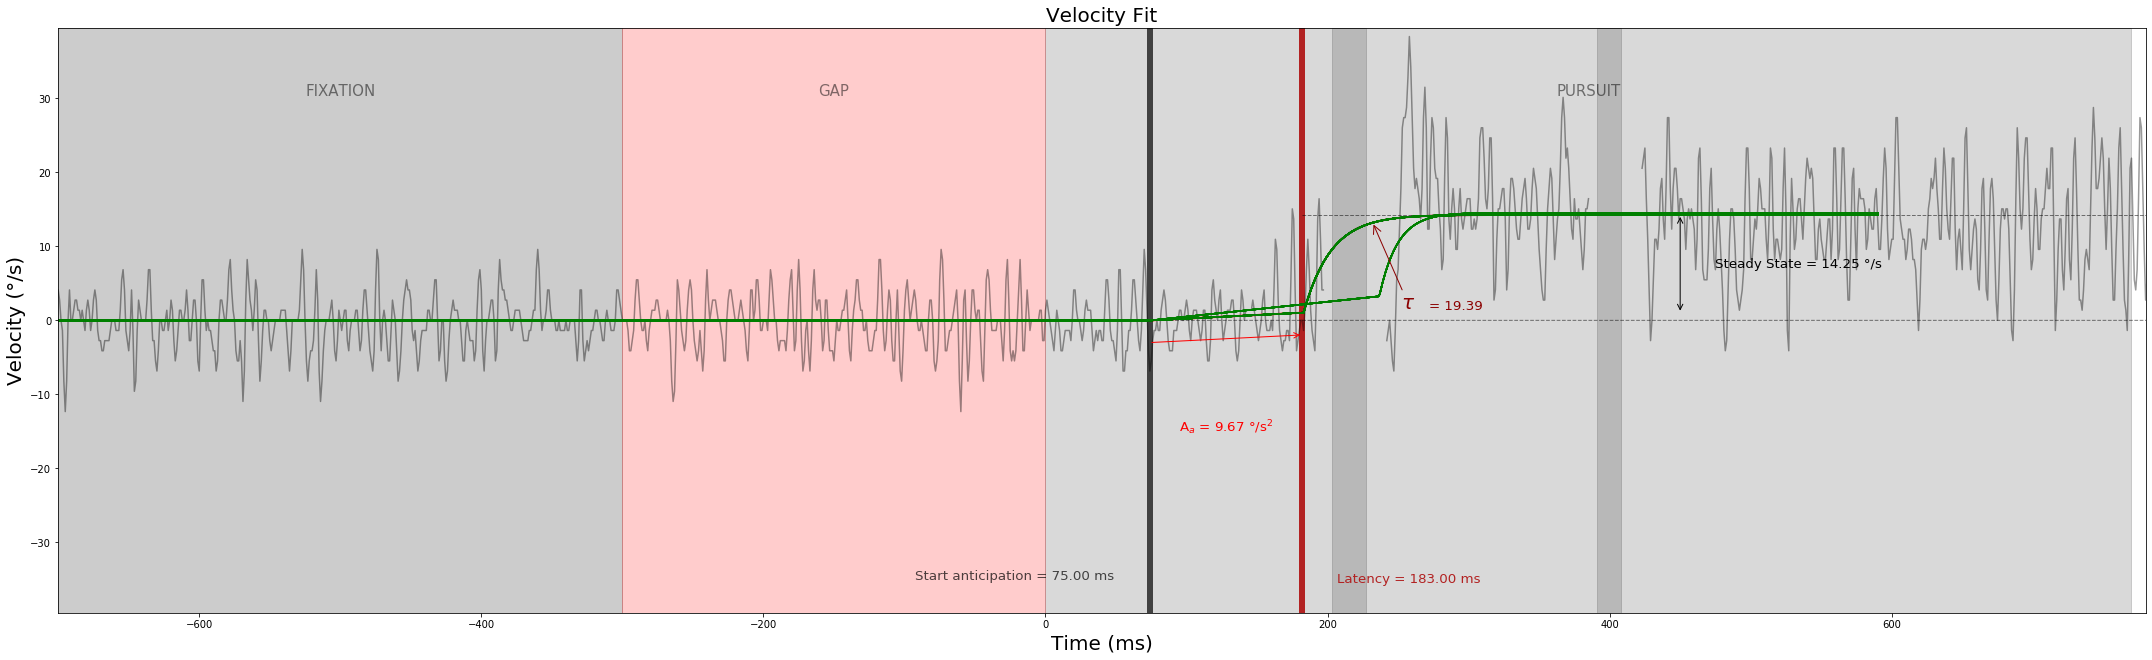

In [5]:
s, t = 0, 11
print(sujets[s])
result_full_data_s0, result_red_data_s0 = moulti_fit(s, t)

CS
[1038.26412865  879.84961013  757.27035301 1033.76077651  784.29859754
  839.04067089  923.61257295  731.89385756  850.17783269  866.33203717
  746.92803633  693.32133076  883.21034673  986.43845268 1046.52419233
 1006.50521337  739.64893651  825.62478637  700.4451755  1026.91515668
  992.5088736   912.43400952  958.66815201  749.17327699  972.36663488
  797.19720133 1007.55339569  986.62764851 1014.07943639  763.79220932
  722.95536063  988.32943048 1065.72977616  947.8472178   865.90813015
  823.85998867  861.20312763  718.26373474  874.62073612 1009.25742966
  993.51723118 1047.85739913  923.78950794  712.62993951  954.33052789
 1034.92953831  824.80765862  707.21270409  818.89767243  917.00317954]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

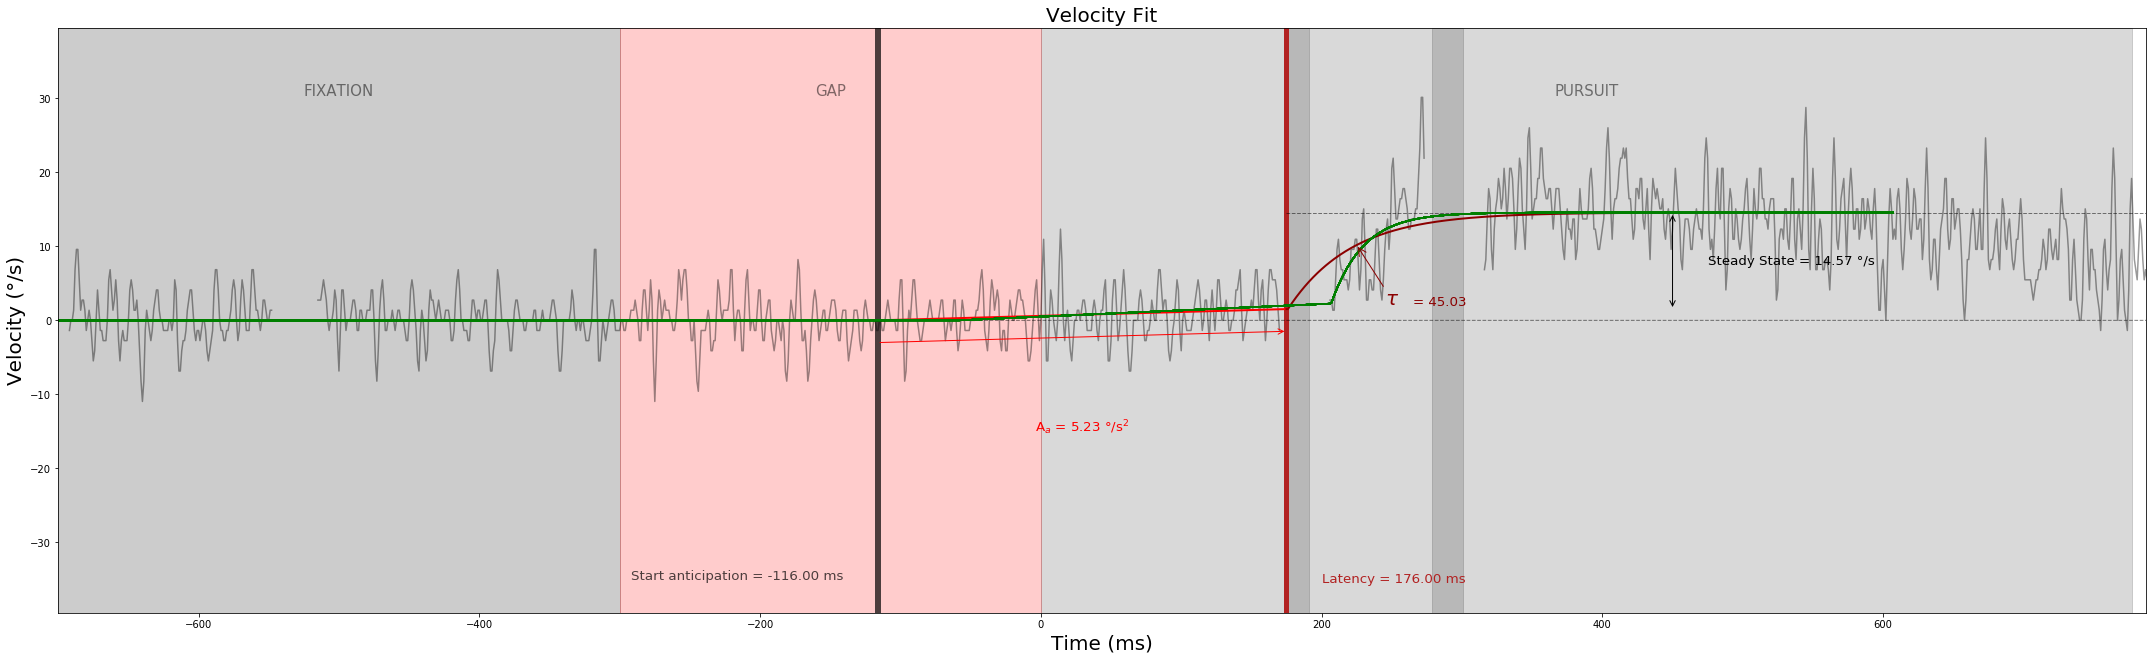

In [6]:
s, t = 2, 11
print(sujets[s])
result_full_data_s2, result_red_data_s2 = moulti_fit(s, t)

DC
[1057.26412865  898.84961013  776.27035301 1052.76077651  803.29859754
  858.04067089  942.61257295  750.89385756  869.17783269  885.33203717
  765.92803633  712.32133076  902.21034673 1005.43845268 1065.52419233
 1025.50521337  758.64893651  844.62478637  719.4451755  1045.91515668
 1011.5088736   931.43400952  977.66815201  768.17327699  991.36663488
  816.19720133 1026.55339569 1005.62764851 1033.07943639  782.79220932
  741.95536063 1007.32943048 1084.72977616  966.8472178   884.90813015
  842.85998867  880.20312763  737.26373474  893.62073612 1028.25742966
 1012.51723118 1066.85739913  942.78950794  731.62993951  973.33052789
 1053.92953831  843.80765862  726.21270409  837.89767243  936.00317954]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

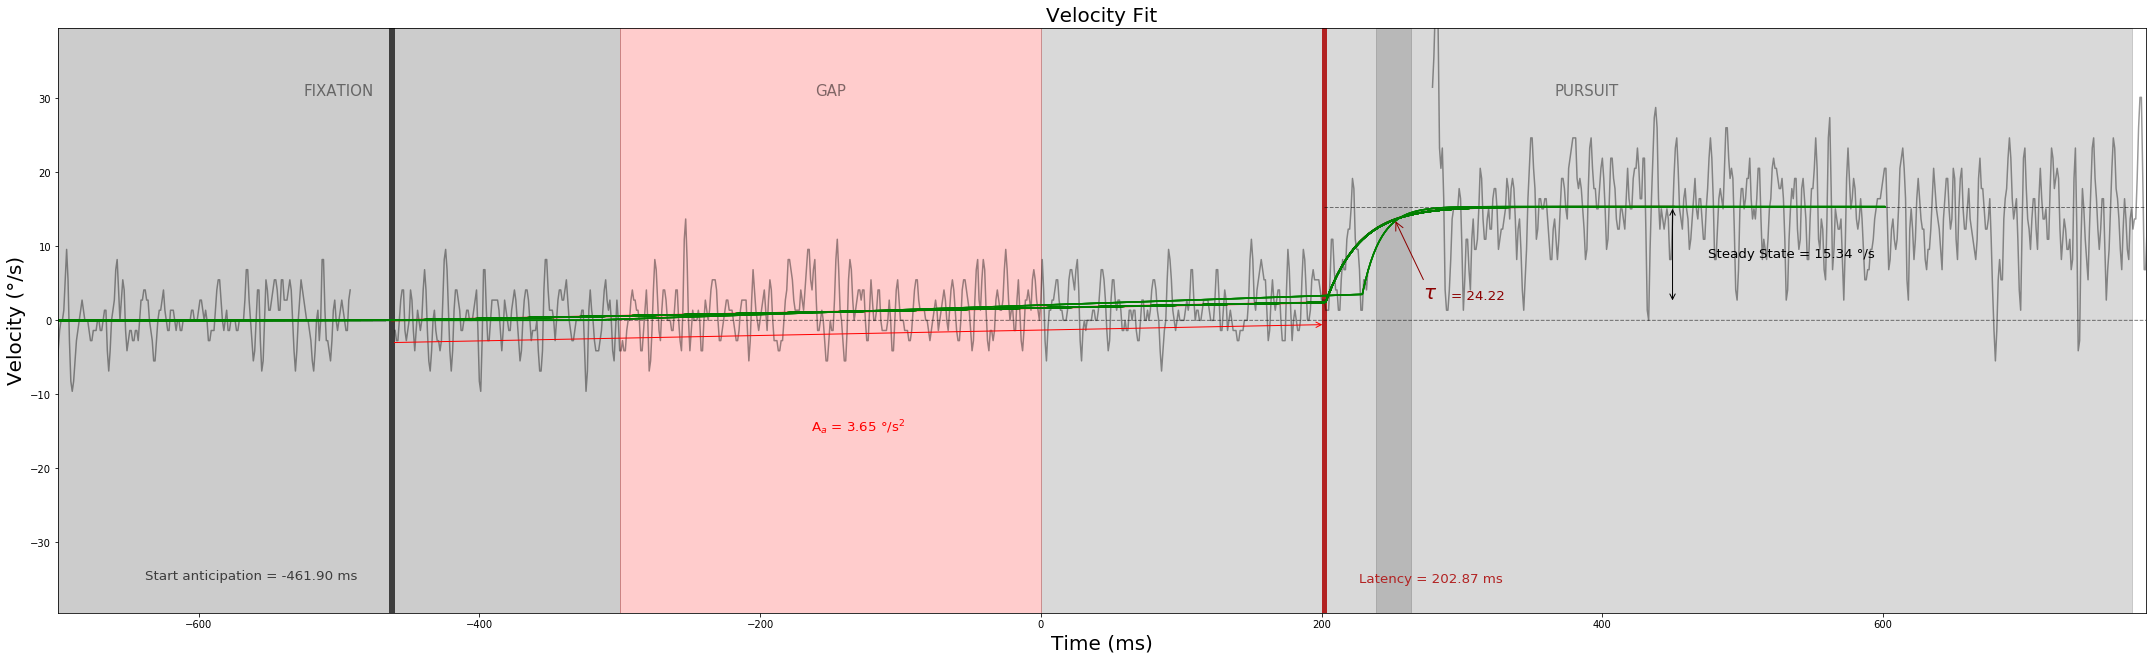

In [7]:
s, t = 3, 11
print(sujets[s])
result_full_data_s3, result_red_data_s3 = moulti_fit(s, t)

IP
[1040.26412865  881.84961013  759.27035301 1035.76077651  786.29859754
  841.04067089  925.61257295  733.89385756  852.17783269  868.33203717
  748.92803633  695.32133076  885.21034673  988.43845268 1048.52419233
 1008.50521337  741.64893651  827.62478637  702.4451755  1028.91515668
  994.5088736   914.43400952  960.66815201  751.17327699  974.36663488
  799.19720133 1009.55339569  988.62764851 1016.07943639  765.79220932
  724.95536063  990.32943048 1067.72977616  949.8472178   867.90813015
  825.85998867  863.20312763  720.26373474  876.62073612 1011.25742966
  995.51723118 1049.85739913  925.78950794  714.62993951  956.33052789
 1036.92953831  826.80765862  709.21270409  820.89767243  919.00317954]


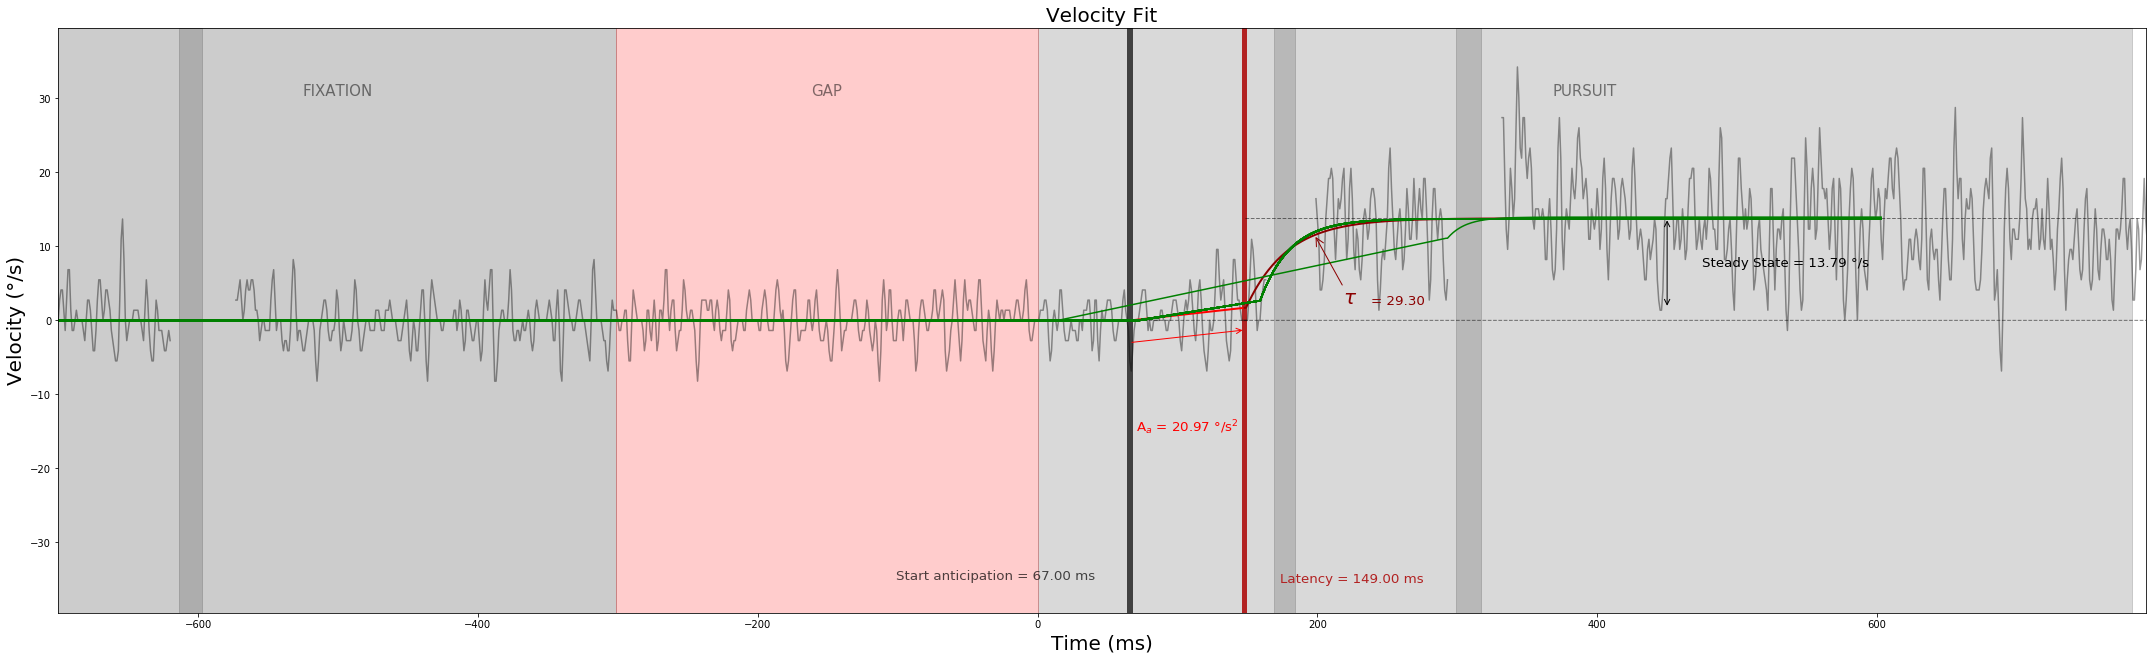

In [8]:
s, t = 5, 11
print(sujets[s])
result_full_data_s5, result_red_data_s5 = moulti_fit(s, t)

# Bad

YK


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


[1370.26412865 1211.84961013 1089.27035301 1365.76077651 1116.29859754
 1171.04067089 1255.61257295 1063.89385756 1182.17783269 1198.33203717
 1078.92803633 1025.32133076 1215.21034673 1318.43845268 1378.52419233
 1338.50521337 1071.64893651 1157.62478637 1032.4451755  1358.91515668
 1324.5088736  1244.43400952 1290.66815201 1081.17327699 1304.36663488
 1129.19720133 1339.55339569 1318.62764851 1346.07943639 1095.79220932
 1054.95536063 1320.32943048 1397.72977616 1279.8472178  1197.90813015
 1155.85998867 1193.20312763 1050.26373474 1206.62073612 1341.25742966
 1325.51723118 1379.85739913 1255.78950794 1044.62993951 1286.33052789
 1366.92953831 1156.80765862 1039.21270409 1150.89767243 1249.00317954]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

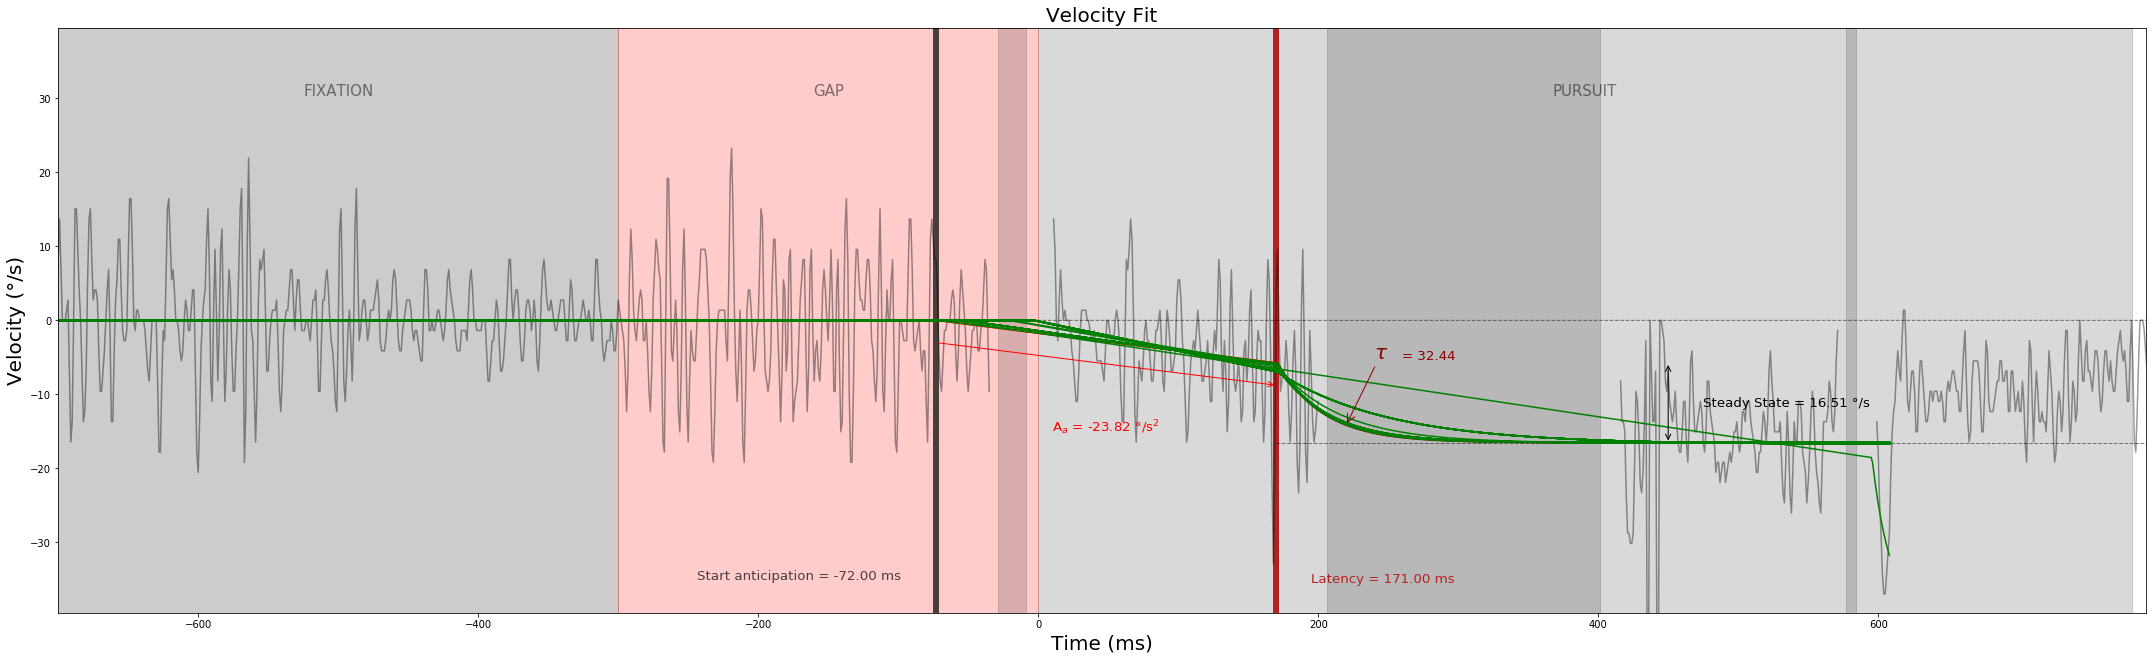

In [9]:
s, t = 11, 58
print(sujets[s])
result_full_data_s11_58, result_red_data_s11_58 = moulti_fit(s, t)

YK
[1294.26412865 1135.84961013 1013.27035301 1289.76077651 1040.29859754
 1095.04067089 1179.61257295  987.89385756 1106.17783269 1122.33203717
 1002.92803633  949.32133076 1139.21034673 1242.43845268 1302.52419233
 1262.50521337  995.64893651 1081.62478637  956.4451755  1282.91515668
 1248.5088736  1168.43400952 1214.66815201 1005.17327699 1228.36663488
 1053.19720133 1263.55339569 1242.62764851 1270.07943639 1019.79220932
  978.95536063 1244.32943048 1321.72977616 1203.8472178  1121.90813015
 1079.85998867 1117.20312763  974.26373474 1130.62073612 1265.25742966
 1249.51723118 1303.85739913 1179.78950794  968.62993951 1210.33052789
 1290.92953831 1080.80765862  963.21270409 1074.89767243 1173.00317954]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

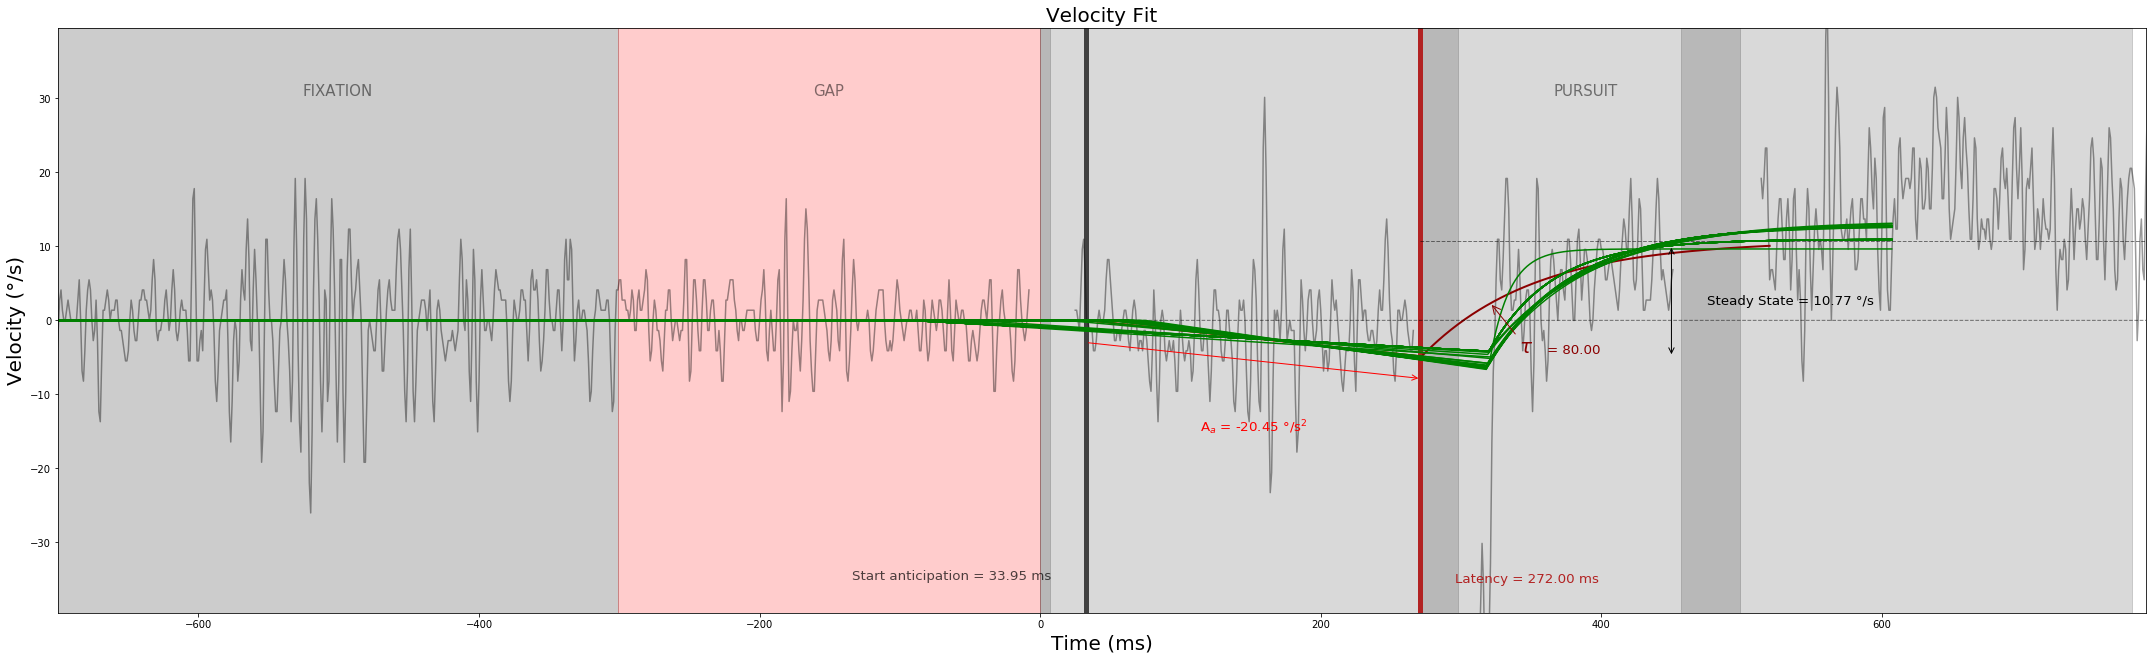

In [10]:
s, t = 11, 82
print(sujets[s])
result_full_data_s11_82, result_red_data_s11_82 = moulti_fit(s, t)

YK
[1380.26412865 1221.84961013 1099.27035301 1375.76077651 1126.29859754
 1181.04067089 1265.61257295 1073.89385756 1192.17783269 1208.33203717
 1088.92803633 1035.32133076 1225.21034673 1328.43845268 1388.52419233
 1348.50521337 1081.64893651 1167.62478637 1042.4451755  1368.91515668
 1334.5088736  1254.43400952 1300.66815201 1091.17327699 1314.36663488
 1139.19720133 1349.55339569 1328.62764851 1356.07943639 1105.79220932
 1064.95536063 1330.32943048 1407.72977616 1289.8472178  1207.90813015
 1165.85998867 1203.20312763 1060.26373474 1216.62073612 1351.25742966
 1335.51723118 1389.85739913 1265.78950794 1054.62993951 1296.33052789
 1376.92953831 1166.80765862 1049.21270409 1160.89767243 1259.00317954]


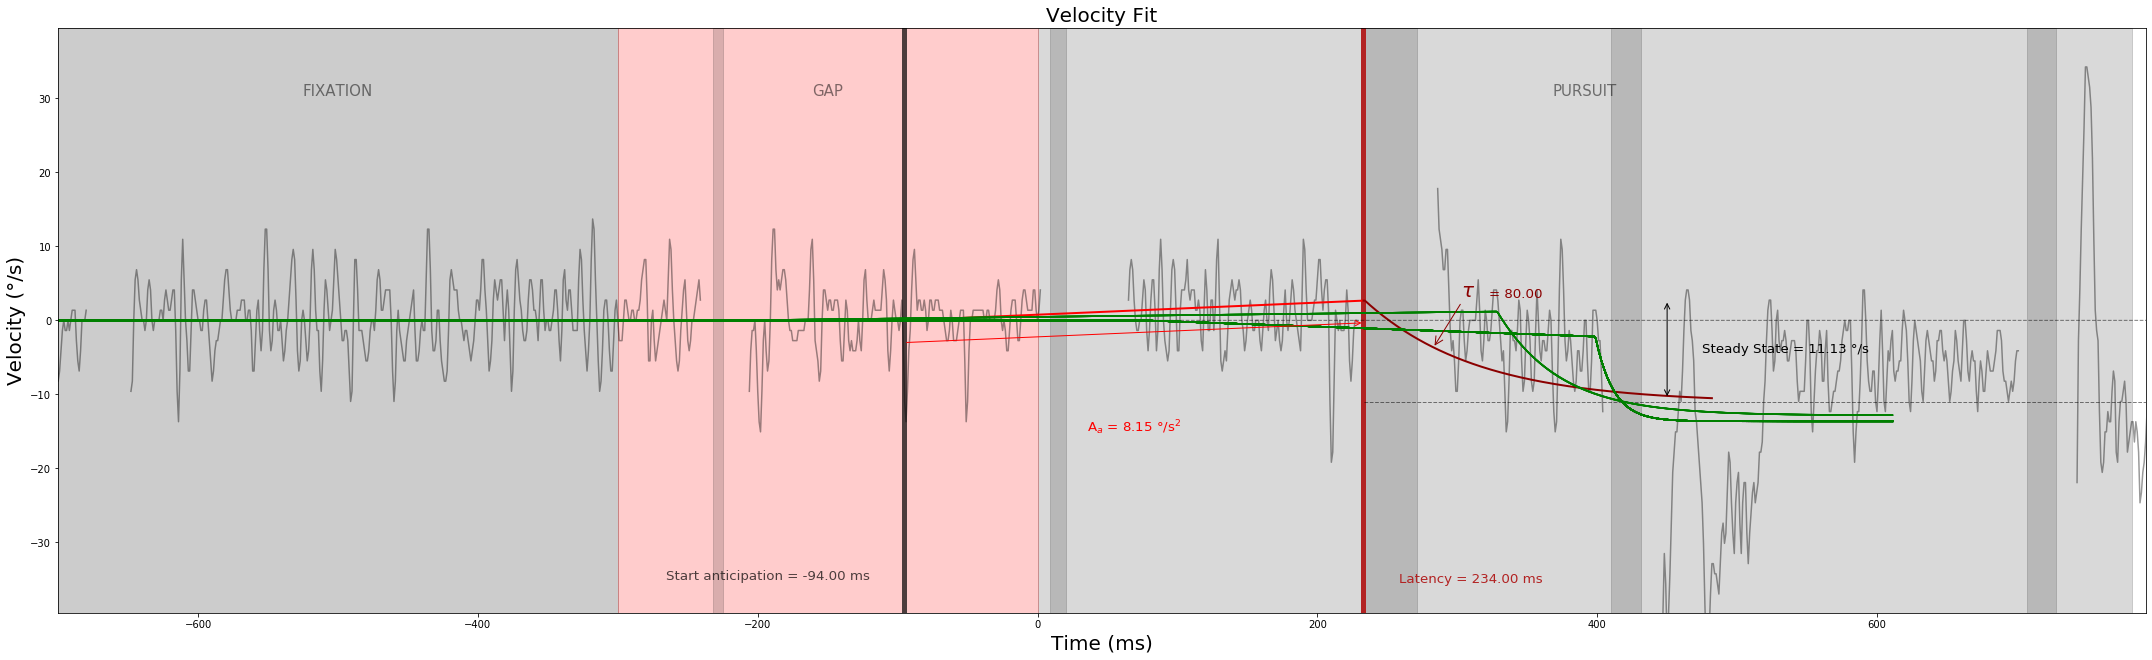

In [11]:
s, t = 11, 190
print(sujets[s])
result_full_data_s11_190, result_red_data_s11_190 = moulti_fit(s, t)

YK
[1623.26412865 1464.84961013 1342.27035301 1618.76077651 1369.29859754
 1424.04067089 1508.61257295 1316.89385756 1435.17783269 1451.33203717
 1331.92803633 1278.32133076 1468.21034673 1571.43845268 1631.52419233
 1591.50521337 1324.64893651 1410.62478637 1285.4451755  1611.91515668
 1577.5088736  1497.43400952 1543.66815201 1334.17327699 1557.36663488
 1382.19720133 1592.55339569 1571.62764851 1599.07943639 1348.79220932
 1307.95536063 1573.32943048 1650.72977616 1532.8472178  1450.90813015
 1408.85998867 1446.20312763 1303.26373474 1459.62073612 1594.25742966
 1578.51723118 1632.85739913 1508.78950794 1297.62993951 1539.33052789
 1619.92953831 1409.80765862 1292.21270409 1403.89767243 1502.00317954]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

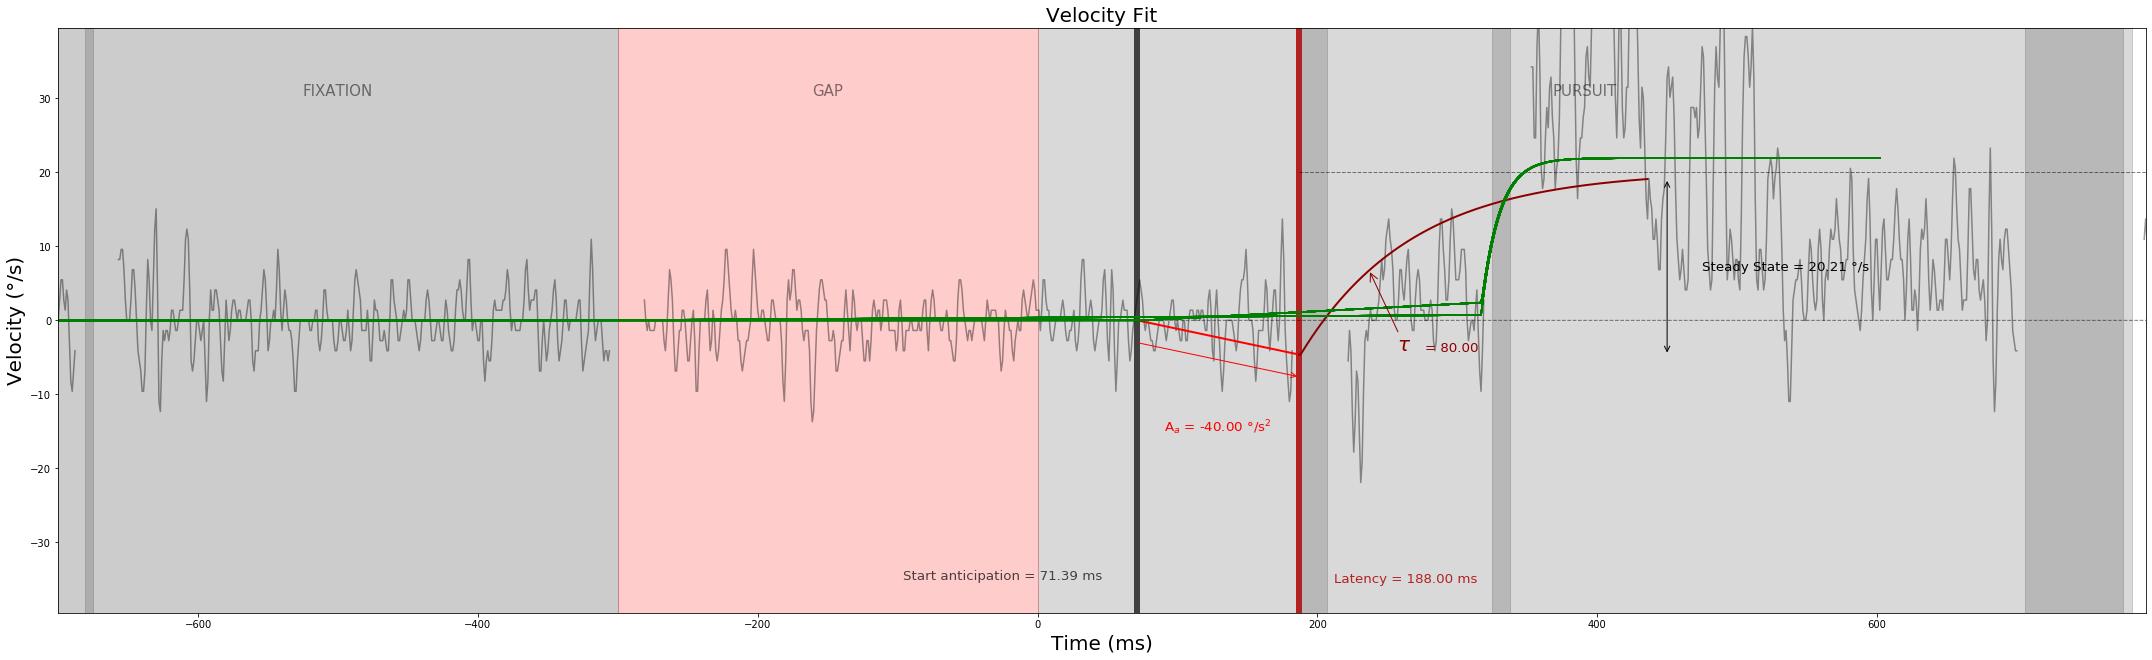

In [12]:
s, t = 11, 191
print(sujets[s])
result_full_data_s11_191, result_red_data_s11_191 = moulti_fit(s, t)

# Hist

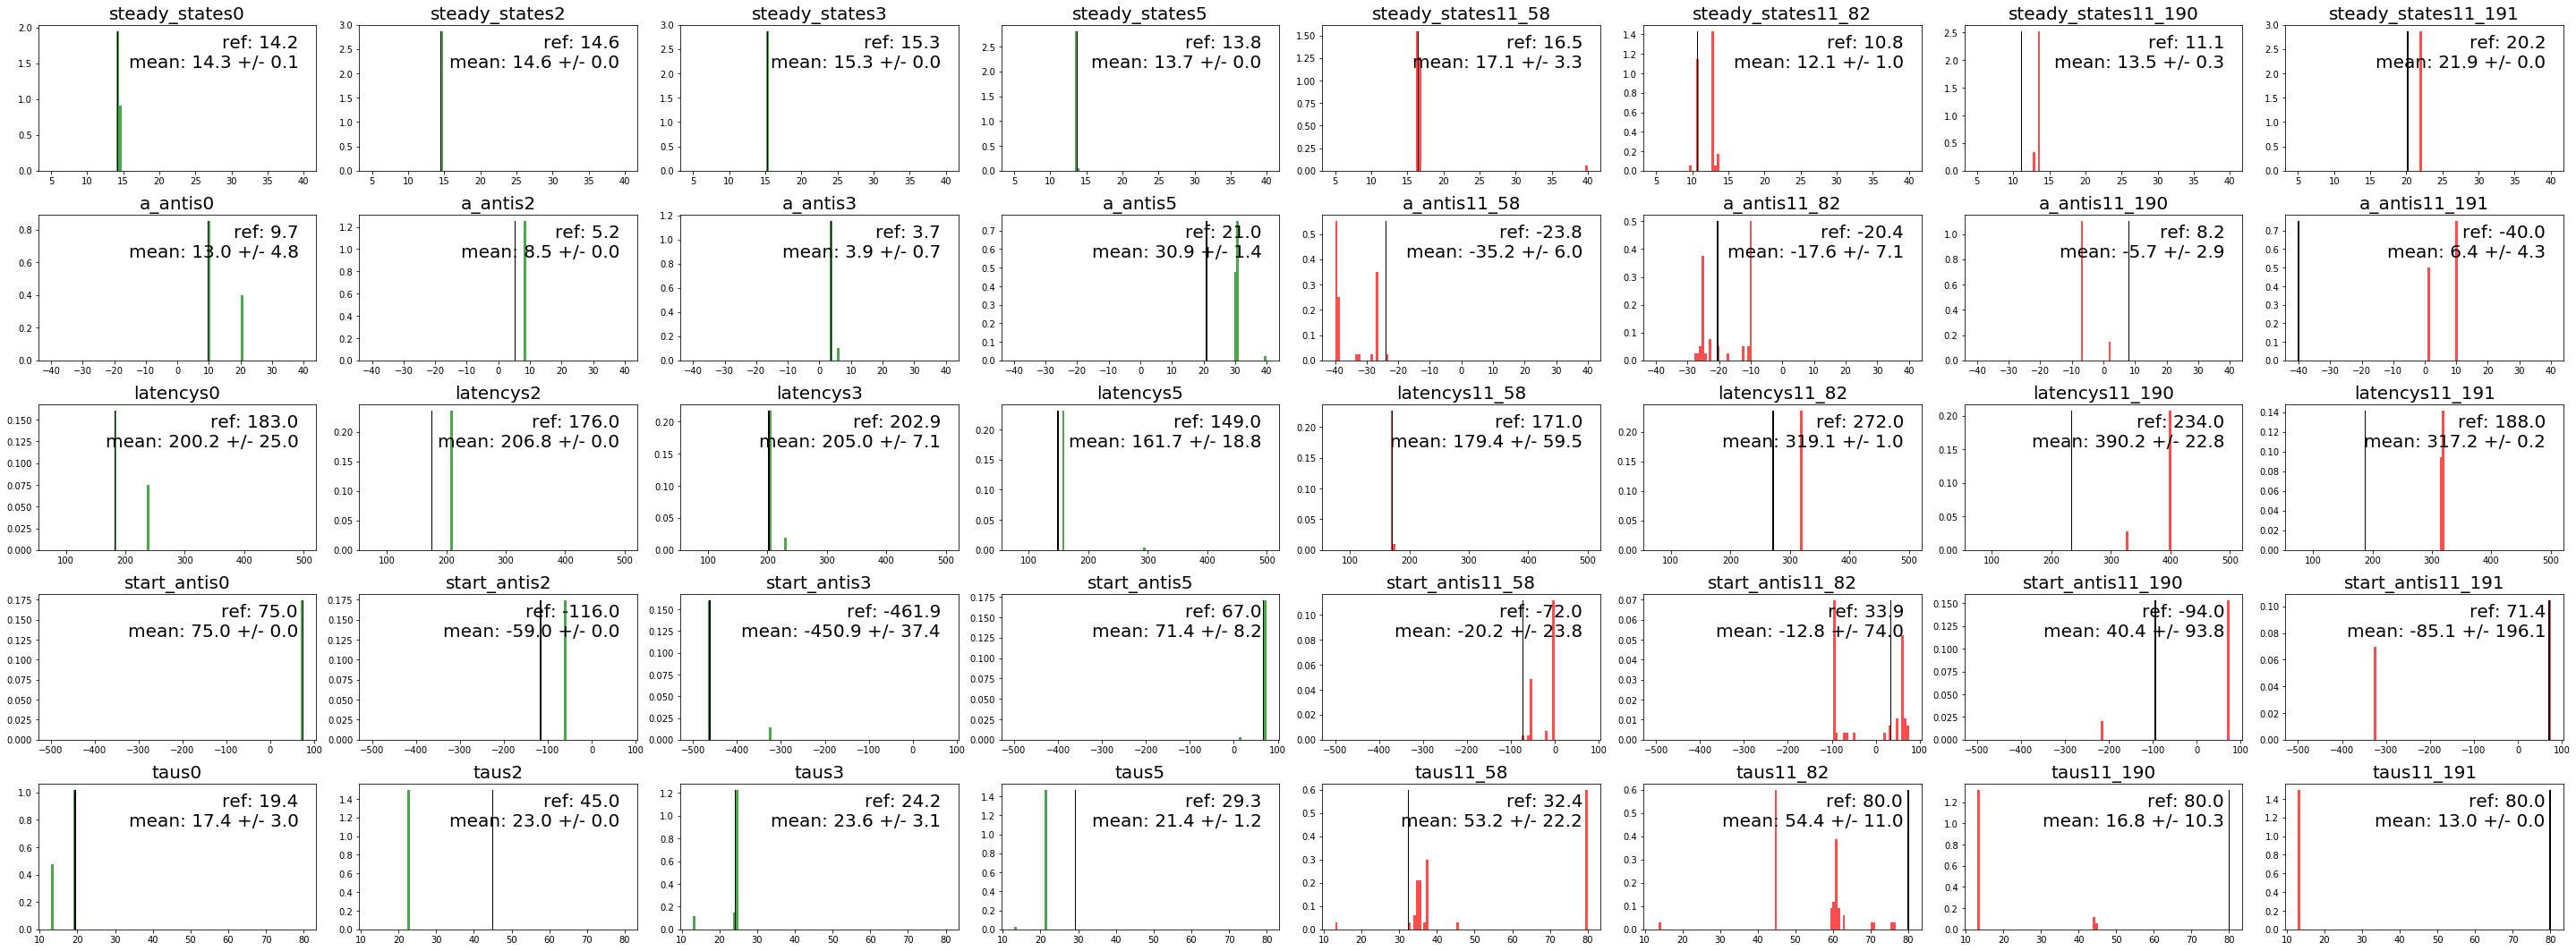

In [13]:
histoto([result_full_data_s0, result_full_data_s2, result_full_data_s3, result_full_data_s5,
         result_full_data_s11_58, result_full_data_s11_82, result_full_data_s11_190, result_full_data_s11_191],
        [result_red_data_s0, result_red_data_s2, result_red_data_s3, result_red_data_s5,
         result_red_data_s11_58, result_red_data_s11_82, result_red_data_s11_190,result_red_data_s11_191],
        ['s0', 's2', 's3', 's5', 's11_58', 's11_82', 's11_190', 's11_191'],
        [ 'g',  'g',  'g',  'g',      'r',      'r',       'r',       'r'], bins=100)